In [1]:
import pyathena as pa
models = dict(
    N128_f01='/Users/jgkim/tigris/bin/hii_N128_f01/',
    # N128_f10='/Users/jgkim/tigris/bin/hii_N128_f10/',
    N128_f10='/Users/jgkim/tigris/bin/hii_N128_f10_thres01/')
    #N128_f10_thres001='/Users/jgkim/tigris/bin/hii_N128_f10_thres001/')

sa = pa.LoadSimAll(models)

In [3]:
# Print photochemistry parameters
for mdl in sa.models:
    s = sa.set_model(mdl)
    print('- Model: ', mdl)
    print(s.par['photchem'])
    print('')

- Model:  N128_f01
{'photchem': 'true', 'mode': 'simple', 'bookkeeping': 'true', 'flag_op_split': 'true', 'flag_rad_force': 'false', 'flag_update_dt_main': 'true', 'f_dt_rad': 0.1, 'hnu[0]': 18.0, 'sigma_d[0]': 0.0, 'sigma_pi_HI[0]': 3e-18, 'hnu[1]': 9.0, 'sigma_d[1]': 1e-21, 'sigma_pi_HI[1]': 0.0, 'tgas_HII': 8000.0, 'tgas_HI': 100.0}

- Model:  N128_f10
{'photchem': 'true', 'mode': 'simple', 'bookkeeping': 'true', 'flag_op_split': 'true', 'flag_rad_force': 'false', 'flag_update_dt_main': 'true', 'f_dt_rad': 1.0, 'hnu[0]': 18.0, 'sigma_d[0]': 0.0, 'sigma_pi_HI[0]': 3e-18, 'hnu[1]': 9.0, 'sigma_d[1]': 1e-21, 'sigma_pi_HI[1]': 0.0, 'tgas_HII': 8000.0, 'tgas_HI': 100.0}



# Mass evolution and time step from history output

{'c': 'C0', 'lw': 1, 'alpha': 1}
{'c': 'C1', 'lw': 2, 'alpha': 0.5}


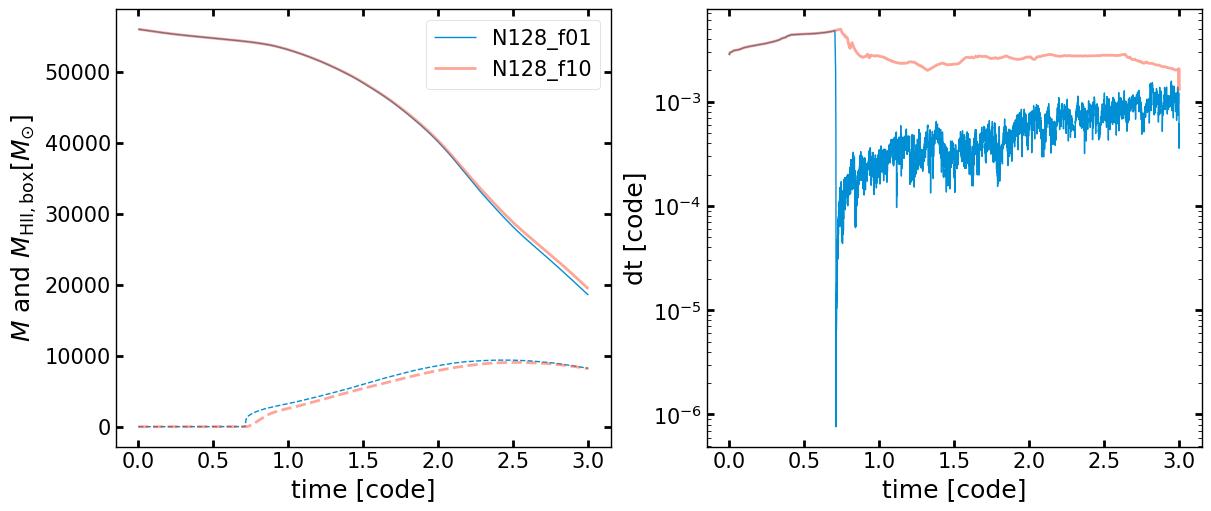

In [4]:
pa.set_plt_fancy()

def plt_hst(s, h, axes, plt_kwargs=dict(ls='-')):
    plt.sca(axes[0])
    plt.plot(h['time'], h['mass']*s.u.Msun, **plt_kwargs)
    plt.plot(h['time'], (h['mass'] - h['0scalar'])*s.u.Msun, ls='--', **plt_kwargs)
    plt.sca(axes[1])
    plt.semilogy(h['time'], h['dt'], **plt_kwargs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt_kwargs = [dict(c='C0', lw=1, alpha=1), dict(c='C1', lw=2, alpha=0.5),
              dict(c='C2', lw=4, alpha=0.3), dict(c='C3',lw=6, alpha=0.3)]
for mdl, kw in zip(sa.models, plt_kwargs):
    print(kw)
    s = sa.set_model(mdl)
    h = pa.read_hst(s.files['hst'])
    plt_hst(s, h, axes, kw)

plt.setp(axes[0], xlabel='time [code]', ylabel=r'$M$ and $M_{\rm HII,box} [M_{\odot}]$')    
plt.setp(axes[1], xlabel='time [code]', ylabel='dt [code]')

axes[0].legend([mpl.lines.Line2D([0], [0], **kw) for kw in plt_kwargs], sa.models);

# Timing analysis

6876
1071


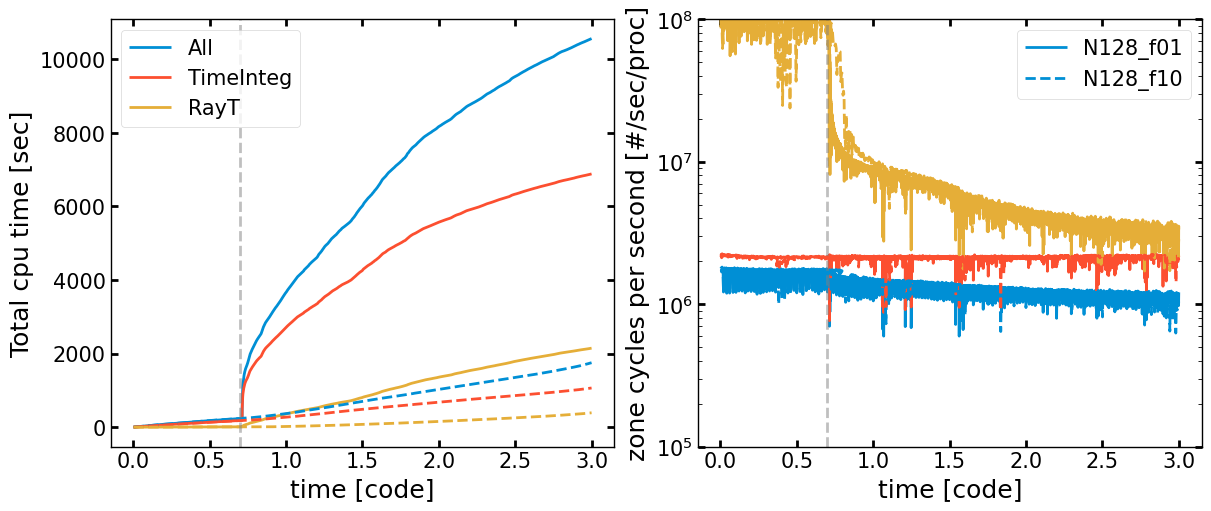

In [5]:
def plt_timing(s, lt, axes, Nproc, plt_kwargs=dict(ls='-'), label=False):
    if label:
        label = ['All', 'TimeInteg', 'RayT']
    else:
        label = ['_no_label_', '_no_label_', '_no_label_']

    plt.sca(axes[0])
    plt.plot(lt['time'], lt['All'].cumsum(),
             c='C0', label=label[0], **plt_kwargs)
    plt.plot(lt['time'], lt['TimeIntegratorTaskList'].cumsum(),
             c='C1', label=label[1], **plt_kwargs)
    plt.plot(lt['time'], lt['RayT'].cumsum(),
             c='C2', label=label[2], **plt_kwargs)
    plt.sca(axes[1])
    Ncell = s.domain['Nx'].prod()
    plt.plot(lt['time'], Ncell/lt['All'], c='C0', **plt_kwargs)
    plt.plot(lt['time'], Ncell/lt['TimeIntegratorTaskList'], c='C1', **plt_kwargs)
    plt.plot(lt['time'], Ncell/lt['RayT'], c='C2', **plt_kwargs)
    
from pyathena.io.timing_reader import TimingReader
Nproc = 8 # How to retrieve Nproc from athena++ simulations?
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt_kwargs = [dict(ls='-'), dict(ls='--'),
              dict(ls=':'), dict(ls='-.')]
label = [True, False, False, False]
for mdl, kw, l in zip(sa.models, plt_kwargs, label):
    s = sa.set_model(mdl)
    tr = TimingReader(s.basedir, s.problem_id)
    lt = tr.load_loop_time()
    plt_timing(s, lt, axes, Nproc, kw, l)
    print(lt.index[-1])

plt.setp(axes[0], xlabel='time [code]', ylabel=r'Total cpu time [sec]')
plt.setp(axes[1], xlabel='time [code]', ylabel=r'zone cycles per second [#/sec/proc]',
         yscale='log', ylim=(1e5,1e8))
for ax in axes:
    ax.axvline(s.par['problem']['t0_src'], c='grey', lw=2, ls='--', alpha=0.5)
axes[0].legend()

axes[1].legend([mpl.lines.Line2D([0], [0], **kw) for kw in plt_kwargs], sa.models);

# Evaporation rate and enclosed mass

- If you are not familiar with the use of xarray, see [xarray tutorial](https://tutorial.xarray.dev/intro.html)

In [6]:
def get_data(s, num):
    # num = s.nums[100]
    dd = s.load_hdf5(num)
    u = s.u
    dvol = s.domain['dx'].prod()
    # Derived fields
    dd['r'] = np.sqrt(dd['x']**2 + dd['y']**2 + dd['z']**2)
    # dd['rho_neu'] = dd['rho']*dd['r0']
    # dd['rho_ion'] = dd['rho']*(1 - dd['r0'])
    
    # Sort cells in ascending order
    idx_ion = dd['r0'] < 0.5
    idx = np.argsort(dd['r'].data.flatten())
    
    rr = dict()
    rr['r'] = dd['r'].data.flatten()[idx]
    rr['Mion_r'] = (dd['rho']*idx_ion).data.flatten()[idx].cumsum()*dvol*u.mass
    rr['Mneu_r'] = (dd['rho']*~idx_ion).data.flatten()[idx].cumsum()*dvol*u.mass
    rr['fV_neu'] = idx_ion.sum()/dd['r0'].size
    rr['fV_ion'] = 1.0 - rr['fV_neu']
    rr['dot_rho_ev'] = -dd['rho_hi_dot'].data.flatten()[idx]
    rr['dot_M_ev'] = rr['dot_rho_ev'].cumsum()*dvol*u.mass/u.time
    rr['time'] = dd.attrs['Time']
    
    return dd, rr

50 70 90 110 130 150 

Text(0.5, 0.98, 'Model: hii_N128_f10_thres01')

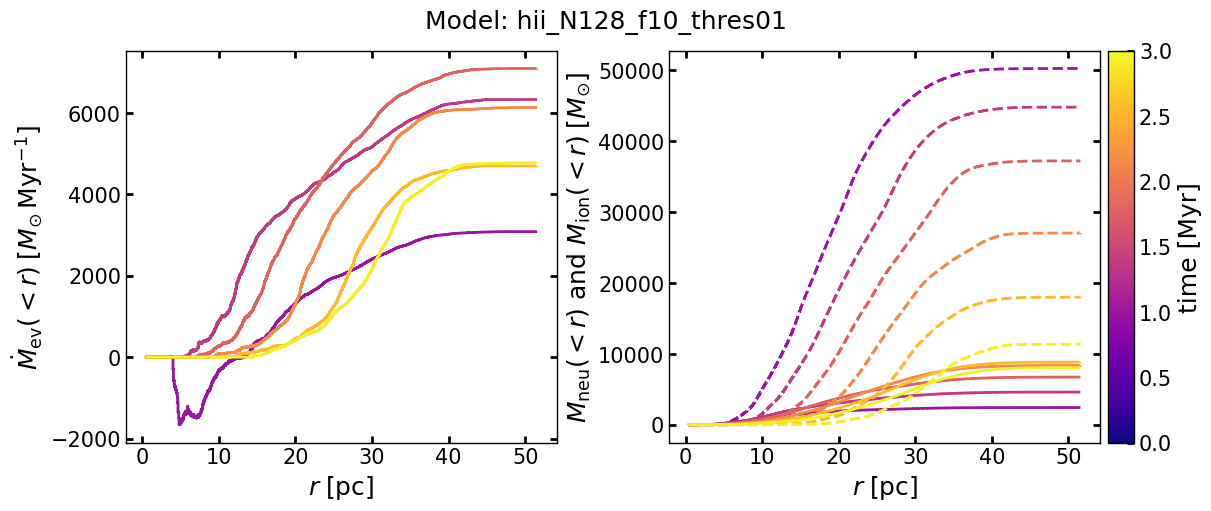

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=[0.5,0.5,0.03]))

tlim = s.par['time']['tlim']
norm = plt.Normalize(0, tlim)
cmap = mpl.cm.plasma
for num in s.nums[50:200:20]:
    print(num, end=' ')
    dd, rr = get_data(s, num)
    plt.sca(axes[0])
    plt.plot(rr['r'], rr['dot_M_ev'], c=cmap(norm(rr['time']*s.u.Myr)))
    plt.sca(axes[1])
    l, = plt.plot(rr['r'], rr['Mion_r'], c=cmap(norm(rr['time']*s.u.Myr)))
    plt.plot(rr['r'], rr['Mneu_r'], c=l.get_color(), ls='--')
    # break

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
plt.colorbar(sm, cax=axes[-1], label='time [Myr]')
plt.setp(axes[0], ylabel=r'$\dot{M}_{\rm ev}(<r)\;[M_{\odot}\,{\rm Myr}^{-1}]$')
plt.setp(axes[1], ylabel=r'$M_{\rm neu}(<r)$ and $M_{\rm ion}(<r)\;[M_{\odot}]$')
plt.setp(axes[0:2], xlabel=r'$r\;[{\rm pc}]$')
plt.suptitle('Model: ' + s.basename)

In [8]:
num = 80
dd = s.load_hdf5(num)
u = s.u
dd

<xarray.Dataset>
Dimensions:      (z: 128, y: 128, x: 128)
Coordinates:
  * x            (x) float32 -29.77 -29.3 -28.83 -28.36 ... 28.83 29.3 29.77
  * y            (y) float32 -29.77 -29.3 -28.83 -28.36 ... 28.83 29.3 29.77
  * z            (z) float32 -29.77 -29.3 -28.83 -28.36 ... 28.83 29.3 29.77
Data variables:
    vel2         (z, y, x) float32 -7.712 -7.813 -7.83 ... 1.988 1.995 1.992
    Fr_rayt01    (z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    x_hi_before  (z, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    rho          (z, y, x) float32 0.001849 0.00188 0.001938 ... 0.206 0.1433
    press        (z, y, x) float32 0.001199 0.001219 0.001257 ... 0.1336 0.09289
    Fr_rayt02    (z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Fr_rayt03    (z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rho_hi_dot   (z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vel3         (z, y, x) float32 -3.798 -3.867 -3.889 ... -0.1966 -0.1984
    Er_rayt0     (z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vel1         (z, y, x) float32 -3.105 -2.613 -2.431 ... 10.01 10.22 10.5
    r0           (z, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes: (12/15)
    Time:           1.6011564
    NumCycles:      530
    RootGridX2:     [-30.  30.   1.]
    RootGridX1:     [-30.  30.   1.]
    MeshBlockSize:  [32 32 32]
    RootGridX3:     [-30.  30.   1.]
    ...             ...
    NumMeshBlocks:  64
    MaxLevel:       0
    RootGridSize:   [128 128 128]
    dx1:            0.46875
    dx2:            0.46875
    dx3:            0.46875

# Density slice (neutral and ionized separately)

Text(0, 0.5, '$y\\;[{\\rm pc}]$')

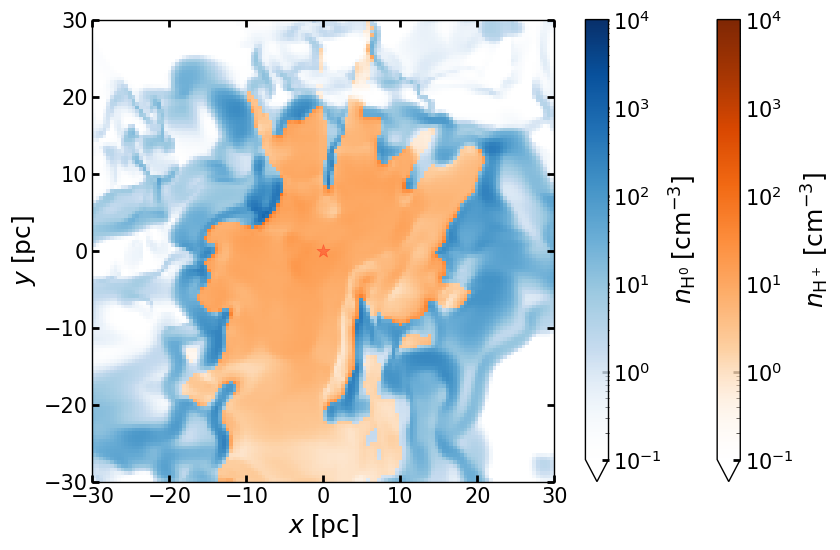

In [9]:
from pyathena.plt_tools.cmap import cmap_apply_alpha

fig = plt.figure(figsize=(10,6))
# Derived fields
dd['r'] = np.sqrt(dd['x']**2 + dd['y']**2 + dd['z']**2)
dd['rho_neu'] = dd['rho']*dd['r0']
dd['rho_ion'] = dd['rho']*(1 - dd['r0'])
idx_ion = dd['r0'] < 0.5

# see https://matplotlib.org/stable/users/explain/colors/colormaps.html
# see also: https://github.com/jeonggyukim/pyathena/blob/master/pyathena/plt_tools/cmap.py#L13-L22
add_colorbar = True
norm = dict(rho_ion=mpl.colors.LogNorm(1e-3*(nH0:=s.par['problem']['nH0']), 1e2*nH0),
            rho_neu=mpl.colors.LogNorm(1e-3*nH0, 1e2*nH0))
cmap = dict(rho_ion=cmap_apply_alpha('Oranges'),
            rho_neu=cmap_apply_alpha('Blues'))
label = dict(rho_ion=r'$n_{\rm H^+}\;[{\rm cm}^{-3}]$',
             rho_neu=r'$n_{\rm H^0}\;[{\rm cm}^{-3}]$')

im1 = (dd['rho']*idx_ion).sel(z=0, method='nearest').\
    plot.imshow(cmap=cmap['rho_ion'], norm=norm['rho_ion'], add_colorbar=add_colorbar, add_labels=False,
                cbar_kwargs=dict(label=label['rho_ion']))
im2 = (dd['rho']*~idx_ion).sel(z=0, method='nearest').\
    plot.imshow(cmap=cmap['rho_neu'], norm=norm['rho_neu'], add_colorbar=add_colorbar, add_labels=False,
                cbar_kwargs=dict(label=label['rho_neu']))
plt.gca().set_aspect('equal')
plt.scatter([0], [0], marker='*', c='r', alpha=0.3, s=1e2)
plt.xlabel(r'$x\;[{\rm pc}]$')
plt.ylabel(r'$y\;[{\rm pc}]$')